<a href="https://www.kaggle.com/code/sitaberete/handwritten-digit-recognizer?scriptVersionId=163511338" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Table of Contents

[1. Data Loading and Preprocessing](#dataprep)<br>
[2. Neural Network With Fully Connected Layers (99.73% validation accuracy)](#dense)<br>
[3. Convolutional Neural Network (99.51% validation accuracy)](#cnn)<br>
[4. Transfert Learning With MobileNet and ImageNet (x% validation accuracy)](#mobilenet)<br>
[5. Submit Result From Best Model](#submit)<br>






## Data Loading and Preprocessing <a id="dataprep"></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt

test_data_path = '/kaggle/input/digit-recognizer/test.csv'
competition_test_data = pd.read_csv(test_data_path)

# train_data_path = '/kaggle/input/digit-recognizer/train.csv'
# train_data = pd.read_csv(train_data_path)

# y = train_data['label']
# X = train_data.drop('label', axis=1)

# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9)

tf.random.set_seed(0)

(X_train, y_train), (X_val, y_val) = tf.keras.datasets.mnist.load_data()

num_classes = len(set(y_train))
f"Number of classes: {num_classes}"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


11490434/11490434 [==============================] - 0s 0us/step


'Number of classes: 10'

In [2]:
X_train.shape

(60000, 28, 28)

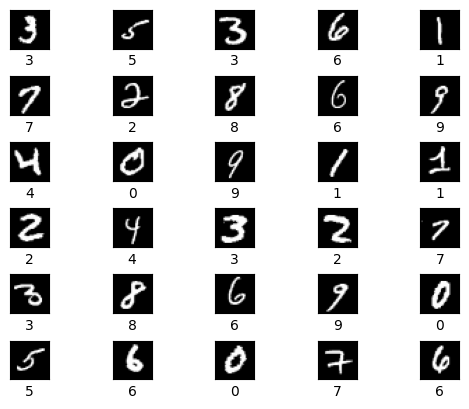

In [3]:
import itertools as iter

def display_digits(images, labels, num_rows, num_cols):
    assert num_rows * num_cols == len(images)
    
    images = images.reshape(num_rows, num_cols, images.shape[1], -1)
    labels = labels.reshape(num_rows, num_cols)
    
    _, grid = plt.subplots(num_rows, num_cols)
    plt.subplots_adjust(hspace=0.7)
    
    rows, cols = range(num_rows), range(num_cols)
    for row, col in iter.product(rows, cols):
        cell = grid[row, col]
        cell.imshow(images[row, col], cmap='gray')
        cell.set(
            xlabel=labels[row, col],
            xticks=[],
            yticks=[]
        )
        
        
display_digits(
    images=X_train[10:40],
    labels=y_train[10:40],
    num_rows=6,
    num_cols=5
)

In [2]:
training_distribution_strategy = tf.distribute.MirroredStrategy()
num_gpus = training_distribution_strategy.num_replicas_in_sync

BATCH_SIZE_PER_REPLICA = 1024
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * num_gpus

print(f'AVAILABLE GPUs: {num_gpus}')

AVAILABLE GPUs: 2


In [3]:
# Normalization:
# x = x - min(x) / max(x) - min(x) equivalent to x = x / max(x) for image since min(x) = 0
X_train = X_train / 255
X_val   = X_val / 255

# One Hot Encoding
y_train = tf.one_hot(y_train, depth=num_classes)
y_val   = tf.one_hot(y_val, depth=num_classes)

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_val shape: ",  X_val.shape)
print("y_val shape: ",  y_val.shape)

X_train shape:  (60000, 28, 28)
y_train shape:  (60000, 10)
X_val shape:  (10000, 28, 28)
y_val shape:  (10000, 10)


## 2. Model with fully connected (Dense) layers <a id="dense"></a>

In [129]:
def train_model(X,y, iterations=60, learning_rate=0.001, _lambda = 0.0004):
    with training_distribution_strategy.scope():
        model = Sequential(
            name= f'lbda-{_lambda}__lr-{learning_rate}__iter-{iterations}',
            layers = [
    #                 layers.Dense(units=30, activation='relu'), # kernel_regularizer=tf.keras.regularizers.L2(_lambda),
    #                 layers.Dropout(0.2),
                layers.Flatten(input_shape=(28, 28)),
                layers.Dense(units=1024, activation='relu'), #kernel_regularizer=tf.keras.regularizers.L2(_lambda)),
                layers.Dropout(0.5),
                layers.Dense(units=512, activation='relu'), #kernel_regularizer=tf.keras.regularizers.L2(_lambda)),
                layers.Dropout(0.5),
                layers.Dense(units=num_classes),# kernel_regularizer=tf.keras.regularizers.L2(_lambda))
            ], 
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            decay_rate=0.45,
            decay_steps=40_000,
            initial_learning_rate=learning_rate,
        )

        model.compile(
            loss= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            optimizer= tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        )

    model.fit(X,y, epochs=iterations, batch_size=BATCH_SIZE)
    return model

models = [
   train_model(X_train, y_train, _lambda=0, learning_rate=learning_rate, iterations=iterations)
#   for iterations, learning_rate in zip([60] * 3,[0.00001, 0.00003, 0.00005])
#   for iterations, learning_rate in zip([60] * 3,[0.00007, 0.0001])
#   for iterations, learning_rate in zip([60] * 2,[0.0002, 0.0004])
#   for iterations, learning_rate in zip([30] * 2,[0.0006, 0.001])
   for iterations, learning_rate in zip([50] ,[0.001])
]

#models = [
#    train_model(X_train, y_train, _lambda=_lambda)
#    for _lambda in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1]
#    for _lambda in [0.0005]
#    for _lambda in [0.0004]
#]

Epoch 1/50
30/30 [==============================] - 3s 14ms/step - loss: 0.7156
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.2521
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.1788
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.1406
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.1190
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.1035
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0878
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0775
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0689
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0613
Epoch 11/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0559
Epoch 12/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0504
Epoch 13/50
30/30 [==================

In [130]:
def get_model_accuracy(model, input, label):
    raw_predictions = model.predict(input)
    predictions = [np.argmax(pred) for pred in raw_predictions]
    oh_predictions = tf.one_hot(predictions, num_classes)
    return np.sum(oh_predictions == label) / tf.size(label)


for index, model in enumerate(models):
    training_accuracy = get_model_accuracy(model, X_train, y_train)
    validation_accuracy = get_model_accuracy(model, X_val, y_val)
    print(f'{model.name}:')
    print(f'Training accuracy = {100*training_accuracy:.2f}%')
    print(f'Validation accuracy = {100*validation_accuracy:.2f}%')
    print('-------------------------------------------------------------')

313/313 [==============================] - 1s 3ms/step
lbda-0__lr-0.001__iter-50:
Training accuracy = 100.00%
Validation accuracy = 99.73%
-------------------------------------------------------------


## 3. Convolutional Neural Network Model  <a id="cnn"></a>

In [92]:
def train_model_conv(X, y, iterations=20, learning_rate=0.001):
    with training_distribution_strategy.scope():
        model = Sequential([
            layers.Reshape(input_shape=(28, 28), target_shape=(28,28,1)),
            layers.Conv2D(filters=32, kernel_size=4, activation='relu'),
            layers.Conv2D(filters=64, kernel_size=4, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Dropout(0.2),
            layers.Conv2D(filters=128, kernel_size=4, activation='relu'),
            layers.MaxPooling2D(pool_size=2, strides=2),
            layers.Dropout(0.2),
            layers.Dense(units=1024, activation='relu'),
            layers.Dropout(0.2),
            layers.Dense(units=512, activation='relu'),
            layers.Dense(units=128, activation='relu'),
            layers.Dropout(0.2),
            layers.Flatten(),
            layers.Dense(units=num_classes)
        ])
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            decay_rate=0.9,
            decay_steps=100_000,
            initial_learning_rate=learning_rate,
        )

        model.compile(
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(lr_schedule),
            metrics=['accuracy']
        )
    
    metrics = model.fit(X,y, epochs=iterations, batch_size=BATCH_SIZE)
    
    return model, metrics

model, metrics = train_model_conv(X_train, y_train, iterations=50)

Epoch 1/50


2024-02-20 04:18:45.354903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_44/dropout_82/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 7s 92ms/step - loss: 0.9218 - accuracy: 0.7049
Epoch 2/50
30/30 [==============================] - 3s 90ms/step - loss: 0.1996 - accuracy: 0.9389
Epoch 3/50
30/30 [==============================] - 3s 90ms/step - loss: 0.1135 - accuracy: 0.9652
Epoch 4/50
30/30 [==============================] - 3s 90ms/step - loss: 0.0827 - accuracy: 0.9748
Epoch 5/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0663 - accuracy: 0.9797
Epoch 6/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0588 - accuracy: 0.9820
Epoch 7/50
30/30 [==============================] - 3s 90ms/step - loss: 0.0532 - accuracy: 0.9842
Epoch 8/50
30/30 [==============================] - 3s 90ms/step - loss: 0.0450 - accuracy: 0.9858
Epoch 9/50
30/30 [==============================] - 3s 92ms/step - loss: 0.0402 - accuracy: 0.9877
Epoch 10/50
30/30 [==============================] - 3s 91ms/step - loss: 0.0366 - accuracy: 0.9888
Epoch 11/50
30/30 [=

313/313 [==============================] - 3s 6ms/step - loss: 0.0220 - accuracy: 0.9947


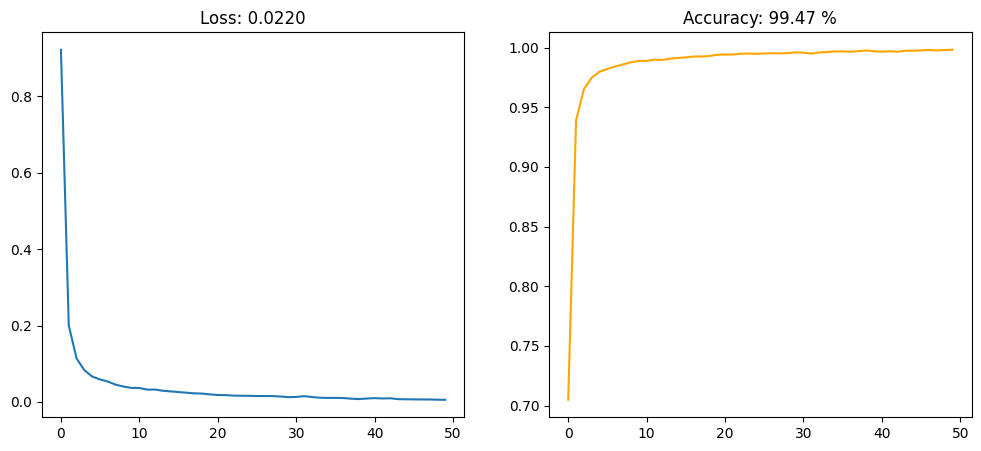

In [93]:
loss, accuracy = model.evaluate(X_val, y_val)

_, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
ax1.plot(metrics.history['loss'])
ax1.set_title(f'Loss: {loss:.4f}')
ax2.plot(metrics.history['accuracy'], c='orange')
ax2.set_title(f'Accuracy: {accuracy * 100:.2f} %')
plt.show()

## 4. Transfert Learning With MobileNet and ImageNet <a id="mobilenet"></a>

## 5. Submit result from best model  <a id="submit"></a>

In [132]:
competition_test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
X_comp_test = tf.reshape(competition_test_data, [competition_test_data.shape[0], 28, 28])
test_predictions = models[0].predict(X_comp_test)
test_predictions = [np.argmax(pred) for pred in test_predictions]
submission_df = pd.DataFrame({'ImageId': competition_test_data.index + 1, 'Label': test_predictions})
display(submission_df)
submission_df.to_csv('submission.csv', index=False)

875/875 [==============================] - 2s 3ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
